# Automated Experimental Bayesian Optimization

This script will predict the next optimal experimental conditions to run

Author: Aleks Siemenn <asiemenn@mit.edu>

**Download and import packages**

In [1]:
import cv2 # pip install opencv-python          # https://pypi.org/project/opencv-python/
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# %matplotlib inline
import seaborn as sns
import pandas as pd
import scipy # requires scipy version 1.4.1 to operate GPyOpt version 1.2.6
from scipy import signal
from scipy import ndimage
# !pip install GPy
# !pip install GPyOpt
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

## BO-CV Optimizer Processflow
rotate_crop() -> watershed_segment(segment_on_dt()) -> CV_loss_label() -> BO_optimizer_func()

## Label of loss value corresponding to each image
## $y_{\textrm{loss}} = \frac{w_{\textrm{count}} \textrm{loss}_{\textrm{count}} + w_{\textrm{area}} \textrm{loss}_{\textrm{area}}}{w_{\textrm{count}} + w_{\textrm{area}}}$

- Droplet count and area losses are multiplied by weights such that $y_{\textrm{loss}}$ represents the relative importance between the two
- The loss label is normalized using a summation of the weights since both $\textrm{loss}_{\textrm{count}}$ and $\textrm{loss}_{\textrm{area}}$ can have a maximum value of 1

In [2]:
min_conds=np.array([0.03,1.0,10.0])
max_conds=np.array([0.150,600.0,300.0])

**Create definitions**

In [3]:
def rotate_crop(img,rotate_crop_params):
    '''
    Rotates and crops the given image.
    
    Inputs:
    img                  := pre-read raw image
    rotate_crop_params   := dictionary of values: {theta, x1, x2, y1, y2}, where
        theta            := angle of counter clockwise rotation
        x1               := start pixel of x-axis crop
        x2               := end pixel of x-axis crop
        y1               := start pixel of y-axis crop
        y2               := end pixel of y-axis crop
    
    Ouputs:
    img                  := rotated and cropped image
    '''
    rotated=ndimage.rotate(img,rotate_crop_params['theta']) # reads image and rotates
    img=rotated[rotate_crop_params['y1']:rotate_crop_params['y2'],rotate_crop_params['x1']:rotate_crop_params['x2']] # crops image
    return img

In [4]:
def segment_on_dt(a, img,threshold):
    '''
    Implements watershed segmentation.
    
    Inputs:
    a         := the raw image input
    img       := threshold binned image
    threshold := RGB threshold value
    
    Outputs:
    lbl       := Borders of segmented droplets
    wat       := Segmented droplets via watershed
    lab       := Indexes of each segmented droplet
    '''
    # estimate the borders of droplets based on known and unknown background + foreground (computed using dilated and erode)
    border = cv2.dilate(img, None, iterations=1)
    border = border - cv2.erode(border, None)
    # segment droplets via distance mapping and thresholding
    dt = cv2.distanceTransform(img, 2, 3)
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
    _, dt = cv2.threshold(dt, threshold, 255, cv2.THRESH_BINARY)
    # obtain the map of segmented droplets with corresponding indices
    lbl, ncc = ndimage.label(dt)
    lbl = lbl * (255 / (ncc + 1))
    lab=lbl
    # Completing the markers now. 
    lbl[border == 255] = 255
    lbl = lbl.astype(np.int32)
    a=cv2.cvtColor(a,cv2.COLOR_GRAY2BGR) # we must convert grayscale to BGR because watershed only accepts 3-channel inputs
    wat=cv2.watershed(a, lbl)
    lbl[lbl == -1] = 0
    lbl = lbl.astype(np.uint8)
    return 255 - lbl, wat,lab # return lab, the segmented and indexed droplets

In [5]:
def watershed_segment(image, double_watershed, large_elements_pixels, pixel_diff, drop_dilate, plot_pixel_diff,remove_log):
    '''
    Applies two-fold watershed image segmentation. First, applies watershed to the
    white interior droplet which fills it in with black. Then, applies watershed
    to the black exterior and filled in droplet.
    
    Inputs:
    image                   := input droplet image to segment
    double_watershed        := True or False value. Determines whether to do single or double watershed.
                               Generally, do True if droplets are big, False is droplets are small.
                               IF FALSE, ARGUMENT VALUES OF "large_elements_pixels", "small_elements_pixels", and "drop_dilate" DON'T MATTER.
    large_elements_pixels   := Cleans large elements that contain more than specified number of pixels.
                               Helpful for removing artefacting borders.
    pixel_diff              := Difference of the number of pixels between regular droplets and small elements.
                               Small elements will be removed if the calculated difference >= user-defined pixel_diff, otherwise pass.
                               Helpful for removing spaces between droplets.
    drop_dialate            := Determines how much to fill in the white interior droplets with black.
    plot_pixel_diff         := True or False value. Plots the segmentation figure of small elements from droplets.
    
    Outputs:
    droplet_count           := Image of droplet interiors indexed by droplet number
    binarized               := Binary image indicating total droplet area vs. empty tube space
    '''
    RGB_threshold=0
    pixel_threshold=0
    img = image.copy()
    if double_watershed==False:
        img=255-img
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img = cv2.medianBlur(img,5)
    _, img_bin = cv2.threshold(img, 0, 255, # threshold image using Otsu's binarization # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
            cv2.THRESH_OTSU)
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN,
            np.ones((4,4), dtype=int))
    # first fold of watershed to remove white centers
    result,water,labs = segment_on_dt(a=img, img=img_bin,threshold=RGB_threshold) # segment droplets from background and return indexed droplets
    # remove large elements
    if double_watershed == True:
        large_elements_thresh=large_elements_pixels
        uniq_full,uniq_counts=np.unique(water,return_counts=True) # get all unique watershed indices with pixel counts
        large_elements=uniq_full[uniq_counts>large_elements_thresh] # mask large elements
        for n in range(len(large_elements)):
            water[water==large_elements[n]]=0 # remove all large elements
        uniq_full,uniq_counts=np.unique(water,return_counts=True) # update list of unique watershed indixes and pixel counts
        uniq_vis_y=np.sort(uniq_counts[1:]) # sort the remaining counts from smallest to largest 
        uniq_delta=[] # initialize list to populate
        Y = 5 # number of elements to take the difference between: n and n+Y elements
        # remove small elements
        for n in range(len(uniq_vis_y)-Y):
            uniq_delta.append(uniq_vis_y[n+Y]-uniq_vis_y[n]) # take the difference between n and n+Y elements
        uniq_delta=np.array(uniq_delta) # convert to np array
        small_elements_thresh=uniq_vis_y[np.argmax(uniq_delta)] # find index where n and n+Y difference is largest
        if plot_pixel_diff==True:
            uniq_vis_x=np.arange(0,len(uniq_vis_y),1)
            plt.figure(figsize=(4,4))
            plt.plot(uniq_vis_x,uniq_vis_y)
            plt.axvline(np.argmax(uniq_delta),color='r',linestyle='--')
            plt.title('First-fold watershed segmentation\nof small elements from droplets')
            plt.xlabel('Element index')
            plt.ylabel('# of pixels')
            plt.show()
        else:
            pass       
        if small_elements_thresh>=pixel_diff: # only if calculated threshold is larger than the user defined small elements do we remove small elements
            small_elements=uniq_full[uniq_counts<=small_elements_thresh] # mask small elements
            for n in range(len(small_elements)):
                water[water==small_elements[n]]=0 # remove all small elements
        else:
            pass
        # remove artefacting spaces between droplets
        uniq_cleaned=np.unique(water) # update list of unique indices after cleaning  
        for n in range(len(uniq_cleaned)):
          shapetest=water.copy() # reset each iteration
          shapetest[shapetest!=uniq_cleaned[n]]=0
          if uniq_cleaned[n] > 0:
            shapetest=shapetest/uniq_cleaned[n]
          else:
            pass
          chord_v=np.sum(shapetest,axis=0) # find the sum of object pixels along x-axis
          chord_h=np.sum(shapetest,axis=1) # find the sum of object pizels along the y-axis
          diff_v=signal.find_peaks(chord_v) # find the peaks of data
          diff_h=signal.find_peaks(chord_h) # find the peaks of data
          if (len(diff_v[0])>1 or len(diff_h[0])>1) and remove_log==True: # if the data is polymodal, remove the objects
            water[water==uniq_cleaned[n]]=0
          else:
            pass
        # second fold of watershed using cleaned image as a base
        water=water/1.
        kernel = np.ones((drop_dilate,drop_dilate),np.uint8)
        water1=cv2.dilate(water,kernel,iterations=1)
        base=image.copy() # begin filling in the droplet centers
        base=cv2.cvtColor(base,cv2.COLOR_RGB2GRAY) # convert image to greyscale
        centers=np.where(water1!=0) # select all watershed segmented centers
        base[centers[0],centers[1]]=np.average(np.unique(base))/4 # convert the color of droplet centers to the darkest color of the base image
        base1=255-base
        _, img_bin = cv2.threshold(base1, 0, 255, # threshold image using Otsu's binarization # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
                cv2.THRESH_OTSU)
        img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN,
                np.ones((5,5), dtype=int))
        result_double,water_double,labs_double = segment_on_dt(a=base, img=img_bin,threshold=RGB_threshold) # segment droplets from background and return indexed droplets
        result_double[result_double==255]=0
        binarized=result_double.copy()
        binarized[binarized!=0]=1
        droplet_count=water1.copy()
        return droplet_count, binarized
    elif double_watershed==False:
        result[result==255]=0
        binarized=result.copy()
        binarized[binarized!=0]=1
        droplet_count=result.copy()
        return droplet_count, binarized
    else:
        raise ValueError("Argument 'double_watershed' takes value either True or False.")

In [6]:
def geom_loss_func(segmented_droplet_img,iter_plot=False):
  '''
  Calculates geometric loss => how closely each droplet maps to a perfect circle.
  If droplets are close to the circle, they obtain a low loss score.

  Inputs:
  segmented_droplet_img      := watershed segmented droplet count image, each individual droplet should have uniquely indexed pixels
  iter_plot                  := True or False value determines whether or not it will plot each droplet mapping to a perfect circle

  Outputs:
  geom_loss                  := value between 0 and 1 that represents how closely ALL droplets map to a perfect circle
  '''
  loss_list=[]
  uniq_select=np.unique(segmented_droplet_img)
  for n in range(len(uniq_select)):
    if n == 0:
      pass
    else:
      uniq=uniq_select[n]
      iterl=segmented_droplet_img.copy()
      iterl[iterl != uniq]=0
      iterl[iterl==uniq]=1
      circle_init=np.zeros(np.shape(iterl))

      # axis 1, summing each row
      uniq_ax1=np.sum(iterl,axis=1)
      start_ax1=np.where(uniq_ax1==uniq_ax1[uniq_ax1>0][0])[0][0] # get the index of the first non-zero row value
      mid_ax1=start_ax1+sum(np.sum(iterl,axis=1)>0)//2 # sum only true values to find the length
      diam_ax1=(np.sum(iterl,axis=1)[mid_ax1]+np.max(uniq_ax1))/2

      # axis 0, summing each column
      uniq_ax0=np.sum(iterl,axis=0)
      start_ax0=np.where(uniq_ax0==uniq_ax0[uniq_ax0>0][0])[0][0] # get the index of the first non-zero row value
      mid_ax0=start_ax0+sum(np.sum(iterl,axis=0)>0)//2 # sum only true values to find the length
      diam_ax0=(np.sum(iterl,axis=0)[mid_ax0]+np.max(uniq_ax0))/2

      radi=int((diam_ax0/2+diam_ax1/2)/2)

      circ=cv2.circle(circle_init,(mid_ax0,mid_ax1),radi,(1,1,1),-1)
      inside=iterl+circ-1
      inside[inside<0]=0
      total = np.abs(circ-iterl)+inside

      lossl=(np.sum(np.abs(circ-iterl))/np.sum(total))*np.sum(iterl) # fraction of droplet not matching perfect circle weighted by the number of pixels in that droplet
      loss_list.append(lossl)
        
        # append geoemtry data to dataframe for every droplet in every sample
      drop_geom.loc[len(drop_geom),:]=[x+2,n,'EI',mid_ax0,mid_ax1,diam_ax0,diam_ax1,np.sum(iterl)] # ['image','droplet','method','centroid_x','centroid_y','chord_x','chord_y','area_pixels']


      if iter_plot==True:
        fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2)
        x0=int(mid_ax0-np.max([radi,np.max(uniq_ax0)]))-20
        x1=int(mid_ax0+np.max([radi,np.max(uniq_ax0)]))+20
        y0=int(mid_ax1-np.max([radi,np.max(uniq_ax1)]))-20
        y1=int(mid_ax1+np.max([radi,np.max(uniq_ax1)]))+20
        ax1.imshow(iterl) 
        ax1.scatter(mid_ax0,mid_ax1,c='r',s=1)
        ax1.set_title('Imaged Droplet #'+str(n))
        ax1.set_xlim([x0,x1]) # zoom into droplet
        ax1.set_ylim([y0,y1]) # zoom into droplet
        ax2.imshow(circ) # zoom into droplet
        ax2.scatter(mid_ax0,mid_ax1,c='r',s=1)
        ax2.set_title('Estimated Droplet\nLoss Label = '+str(round(lossl,3)))
        ax2.set_xlim([x0,x1]) # zoom into droplet
        ax2.set_ylim([y0,y1]) # zoom into droplet
        plt.show()
      else:
        pass
  total_pixels=np.sum(segmented_droplet_img!=0) # total number of droplet pixels
  geom_loss=np.sum(loss_list)/total_pixels # sum the individual losses (each weighted by # of pixels in each droplet) and divide by total number of droplet pixels
  return geom_loss

In [7]:
def CV_loss_label(img, w_count, w_area, w_geom, double_watershed, rotate_crop_params, remove_log, large_elements_pixels=2000, pixel_diff=50, drop_dilate=5, plot_pixel_diff=True):
    '''
    img                     := pre-read raw image
    w_count                 := the weight on the count of droplets loss component
    w_area                  := the weight on the area of droplets to tube space loss component
    w_geom                  := the weight on the geometric loss component
    double_watershed        := True or False value. Determines whether to do single or double watershed.
                               Generally, do True if droplets are big, False is droplets are small.
                               IF FALSE, ARGUMENT VALUES OF "large_elements_pixels", "small_elements_pixels", and "drop_dilate" DON'T MATTER.
    rotate_crop_params      := dictionary of values: {theta, x1, x2, y1, y2}, where
        theta               := angle of counter clockwise rotation
        x1                  := start pixel of x-axis crop
        x2                  := end pixel of x-axis crop
        y1                  := start pixel of y-axis crop
        y2                  := end pixel of y-axis crop
    large_elements_pixels   := Cleans large elements that contain more than specified number of pixels.
                               Helpful for removing artefacting borders.
    pixel_diff              := Difference of the number of pixels between regular droplets and small elements.
                               Small elements will be removed if the calculated difference >= user-defined pixel_diff, otherwise pass.
                               Helpful for removing spaces between droplets. 
                               Larger values stop droplets from being removed if no small elements are detected.
    drop_dialate            := Determines how much to fill in the white interior droplets with black.
    plot_pixel_diff         := True or False value. Plots the segmentation figure of small elements from droplets.
   '''
    image = rotate_crop(img,rotate_crop_params=rotate_crop_params) # reads image, rotates, and crops
    droplet_count,binarized = watershed_segment(image=image, double_watershed=double_watershed, large_elements_pixels=large_elements_pixels, pixel_diff=pixel_diff, drop_dilate=drop_dilate, plot_pixel_diff=plot_pixel_diff,remove_log=remove_log) # computes watershed segmentation
    num_droplets = len(np.unique(droplet_count)) # gets number of unique droplets
    droplets_loss = (150-num_droplets)/150 # pick an arbitrary max number of droplets (100) to create a loss value (i.e., we want to achieve 100 droplets) then normalize. This max number of droplets should be larger than the expected achieveable value so it is always <= 1.0   
    area_loss = np.count_nonzero(binarized==0)/binarized.size # background pixels/total pixels ==> want to minimize this
    geom_loss=geom_loss_func(segmented_droplet_img=droplet_count,iter_plot=False)
    cv_loss=(w_count*droplets_loss + w_area*area_loss + w_geom*geom_loss)/(w_count+w_area+w_geom)
    ################# PLOTTING CODE #####################
    #####################################################
    fig,ax=plt.subplots(figsize=(15,20),ncols=3,nrows=1)
    ax[0].imshow(image)
    ax[0].set_title('Raw Image')
    ax[1].imshow(droplet_count,cmap='jet')
    ax[1].set_title('Indexed\nDroplet Cores')
    ax[2].imshow(binarized,cmap='Greys')
    ax[2].set_title('Binarized, Segmented\nDroplet Area')
#     plt.savefig(impath+'drop_im'+str(time.time()).replace('.','')+'.png',dpi=300)
    plt.show()
    #####################################################
    #####################################################
    
    return droplets_loss, area_loss, geom_loss, cv_loss, num_droplets, binarized

In [8]:
def read_raw(image_path,cond_path,batch_size):
    '''
    Implements raw image reader.
    
    Inputs:
    image_path  := file path to the sample images with names n.jpg where n is the sample number (e.g., 2.jpg, 10.jpg)
    cond_path   := file path to the csv file of conditions used to print the images. Rows correspond to the sample number and columns correspond to the printing conditions (e.g. Pressure, Frequency, Speed)
    batch_size  := number of samples, n
    
    Outputs:
    drop_fulls  := numpy array of the n sample images of 1280x720 resolution (n by x pixels by y pixels)
    param_labs  := numpy array of normalized printer conditions (n by 2)
    '''
    params_3d=np.genfromtxt(cond_path,delimiter=',') # read csv
    params_3d=params_3d[1:,1:] # only select the data, skip first row and column
    # assign parameter values to each image.
    param_labs=[]
    drop_fulls=[]
    # Read the droplet image and condition data
    for n in range(batch_size): # n sample images
#         img = cv2.imread(image_path+'S'+str(n+1)+'e.jpg',cv2.IMREAD_UNCHANGED) # read images
        img = cv2.imread(image_path+str(n+1)+'.jpg',cv2.IMREAD_UNCHANGED) # read images
        param_labs.append(params_3d[n,:])
        drop_fulls.append(img) # fix the resolution of all the images
    # convert data and images to numpy arrays
    param_labs=np.array(param_labs)
    param_raw=np.copy(param_labs)
    drop_fulls=np.array(drop_fulls)
    # normalize each column of parameter values
    for n in range(3):
        # 0 == pressure
        # 1 == frequency
        # 2 == speed
        param_labs[:,n]=(param_labs[:,n]-min_conds[n])/(max_conds[n]-min_conds[n])

    return drop_fulls, param_labs,param_raw

In [9]:
def BO_optimizer_func(X, Y, batch_size):
    '''
    Implement Bayesian optimization.
    
    Inputs:
    X          := input condition matrix (n by 4) where n is the initialized batch size
    Y          := column vector of labels (n by 1)
    batch_size := desired output batch size for the suggested next locations
    
    Ouputs:
    optimizer  := a BO model object
    '''
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)}, # 3D bounds
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 1)},
          ]

    kernel = GPy.kern.Matern52(input_dim=len(bds), ARD = True) # Use the matern 5/2 kernel with automatic relevence detection enabled
    optimizer = BayesianOptimization(f=None, 
                                     domain=bds,
                                     constraints = None,
                                     model_type='GP', # gaussian process model
                                     acquisition_type ='EI', # expected improvement acquisition
                                     acquisition_jitter = 0.01, # tune to adjust exploration (changed from 0.1 -> 0.01 => more exploration). Then changed back to 0.1  
                                     X=X, # input data
                                     Y=Y, # associated labels
                                     evaluator_type = 'local_penalization',
                                     batch_size = batch_size, # batch size of predicted optima
                                     normalize_Y= False,
                                     kernel = kernel # select the kernel
                                     )

    return optimizer

# **Edit code below to run Bayesian Optimization**

In [10]:
# create dataframe to iteratively append droplet geometry data to (chordal length, centroid location, pixel area)
col_names=['image','droplet','method','centroid_x','centroid_y','chord_x','chord_y','area_pixels']
drop_geom=pd.DataFrame(columns=col_names)

## Failure logs (change for EI vs MPI vs LCB)

In [11]:
remove_log={1:False,# add new elements to this log. If you want it to remove small objects for the sample, put True, if not put False
            2:False, 
            3:False,
            4:False,
            5:False,
            6:False,
            7:False,
            8:False,
            9:False,
            10:False,
            11:False,
            12:False,
            13:False,
            14:False,
            15:True,
            16:False,
            17:False,
            18:False,
            19:False,
            20:False,# last initialization sample
            21:False,
            22:False,
            23:False,
            24:False,
            25:False,
            26:False,
            27:False,
            28:False,
            29:False,
            30:False,
            31:False,
            32:False,
            33:False,
            34:False,
            35:False,
            36:False,
            37:False,
            38:False,
            39:False,
            40:False,
            41:False,
            42:False,
            43:False,
            44:False,
            45:False,
            46:False,
            47:False,
            48:False,
            49:False,
            50:False,
            51:False,
            52:False,
            53:False,
            54:False,
            55:False,
            56:False,
            57:False,
            58:False,
            59:False,
            60:False}


##################################################
# failure_log={1:True, ## EI FAILURE LOG
#             2:True, # add new elements to this log. If you want it to overwrite the loss score for a failed sample put True otherwise False
#             3:True,
#             4:True,
#             5:True,
#             6:True,
#             7:True,
#             8:True,
#             9:False,
#             10:True,
#             11:False,
#             12:False,
#             13:False,
#             14:True,
#             15:False,
#             16:False,
#             17:False,
#             18:True,
#             19:True,
#             20:False, # last initialization sample
#             21:True,
#             22:False,
#             23:False,
#             24:False,
#             25:False,
#             26:False,
#             27:False,
#             28:False,
#             29:False,
#             30:False,
#             31:False,
#             32:False,
#             33:False,
#             34:False,
#             35:False,
#             36:True,
#             37:False,
#             38:True,
#             39:False,
#             40:False,
#             41:False,
#             42:False,
#             43:False,
#             44:False,
#             45:False,
#             46:False,
#             47:False,
#             48:False,
#             49:False,
#             50:False,
#             51:False,
#             52:True,
#             53:False,
#             54:False,
#             55:False,
#             56:False,
#             57:False,
#             58:False,
#             59:False,
#             60:True}


###################################################
# failure_log={1:True, ## MPI FAILURE LOG
#             2:True, # add new elements to this log. If you want it to overwrite the loss score for a failed sample put True otherwise False
#             3:True,
#             4:True,
#             5:True,
#             6:True,
#             7:True,
#             8:True,
#             9:False,
#             10:True,
#             11:False,
#             12:False,
#             13:False,
#             14:True,
#             15:False,
#             16:False,
#             17:False,
#             18:True,
#             19:True,
#             20:False, # last initialization sample
#             21:False,
#             22:False,
#             23:False,
#             24:False,
#             25:False,
#             26:True,
#             27:False,
#             28:False,
#             29:False,
#             30:True,
#             31:False,
#             32:False,
#             33:False,
#             34:False,
#             35:False,
#             36:False,
#             37:True,
#             38:False,
#             39:False,
#             40:False,
#             41:False,
#             42:False,
#             43:False,
#             44:False,
#             45:True,
#             46:True,
#             47:True,
#             48:True,
#             49:False,
#             50:False,
#             51:False,
#             52:False,
#             53:True,
#             54:False,
#             55:False,
#             56:True,
#             57:False,
#             58:True,
#             59:True,
#             60:True}



# ################################################
failure_log={1:True, ## LCB FAILURE LOG
            2:True, # add new elements to this log. If you want it to overwrite the loss score for a failed sample put True otherwise False
            3:True,
            4:True,
            5:True,
            6:True,
            7:True,
            8:True,
            9:False,
            10:True,
            11:False,
            12:False,
            13:False,
            14:True,
            15:False,
            16:False,
            17:False,
            18:True,
            19:True,
            20:False, # last initialization sample
            21:False,
            22:False,
            23:False,
            24:False,
            25:False,
            26:False,
            27:True,
            28:False,
            29:False,
            30:True,
            31:True,
            32:True,
            33:True,
            34:True,
            35:False,
            36:False,
            37:True,
            38:True,
            39:False,
            40:False,
            41:True,
            42:True,
            43:True,
            44:True,
            45:False,
            46:True,
            47:True,
            48:True,
            49:False,
            50:True,
            51:False,
            52:False,
            53:True,
            54:True,
            55:True,
            56:True,
            57:True,
            58:False,
            59:True,
            60:False}

## Read data

In [12]:
path= 'file path'
impath='image path'
batch = 60 # change the batch size here (samples 2-17 are initialization data)

images,conds,cond_raw=read_raw(image_path=path, cond_path=path+'file.csv',batch_size=batch)
# images,conds,cond_raw=read_raw(image_path=path, cond_path=path+'Set_4_params.csv',batch_size=batch)

## Process & score images

In [13]:
# Create constraint variable: number of droplets
drop_number=np.zeros(batch)

Sample # 1 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 2 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 3 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 4 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 5 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 6 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 7 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 8 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




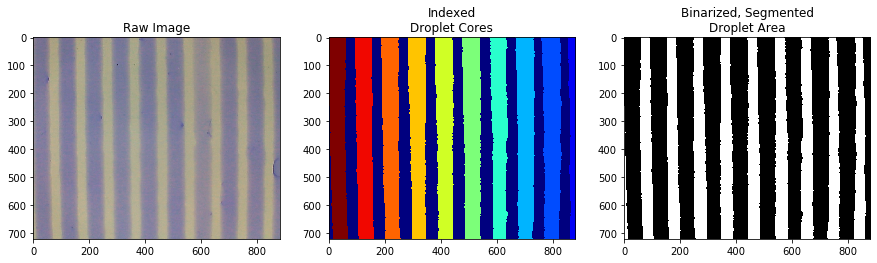

Sample # 9 
Count Loss =  0.9267 
Area Loss =  0.397 
Geometric Loss =  0.8278 
FINAL LOSS SCORE =  0.717 


Sample # 10 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




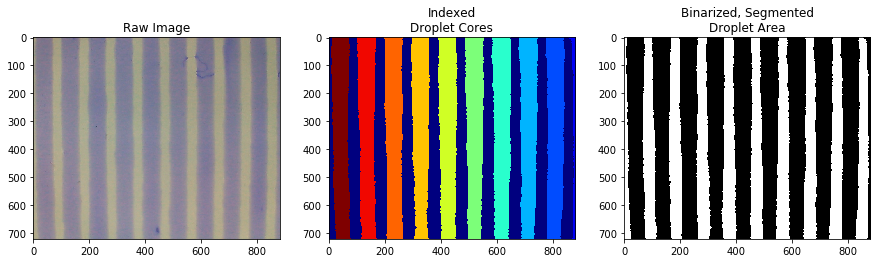

Sample # 11 
Count Loss =  0.9267 
Area Loss =  0.4054 
Geometric Loss =  0.827 
FINAL LOSS SCORE =  0.72 




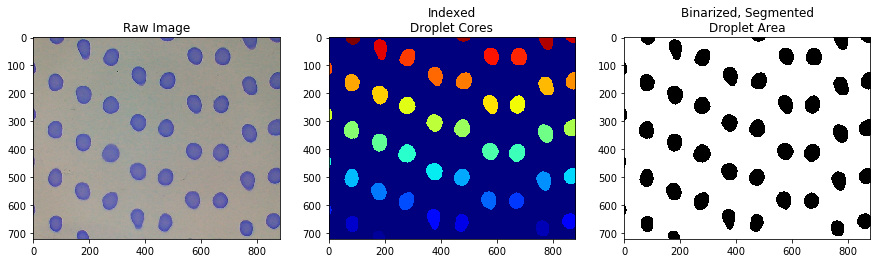

Sample # 12 
Count Loss =  0.6933 
Area Loss =  0.8394 
Geometric Loss =  0.1606 
FINAL LOSS SCORE =  0.564 




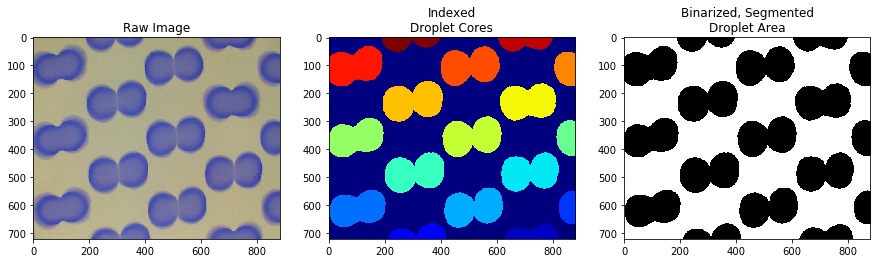

Sample # 13 
Count Loss =  0.88 
Area Loss =  0.5811 
Geometric Loss =  0.4304 
FINAL LOSS SCORE =  0.63 


Sample # 14 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




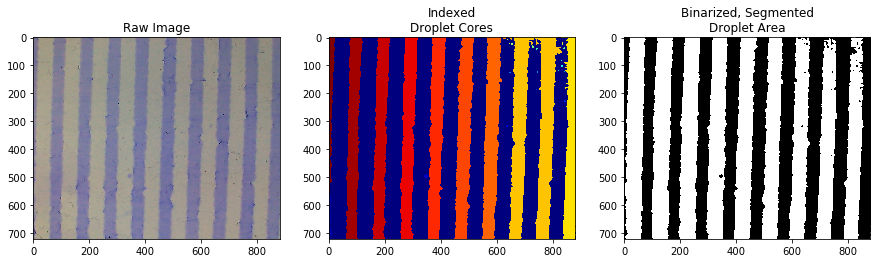

Sample # 15 
Count Loss =  0.7933 
Area Loss =  0.5472 
Geometric Loss =  0.8449 
FINAL LOSS SCORE =  0.728 




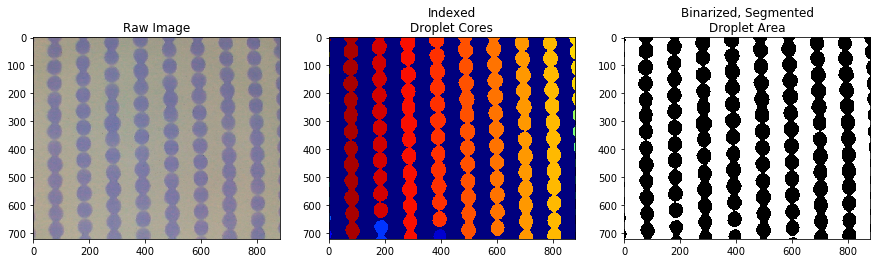

Sample # 16 
Count Loss =  0.8067 
Area Loss =  0.6175 
Geometric Loss =  0.8551 
FINAL LOSS SCORE =  0.76 




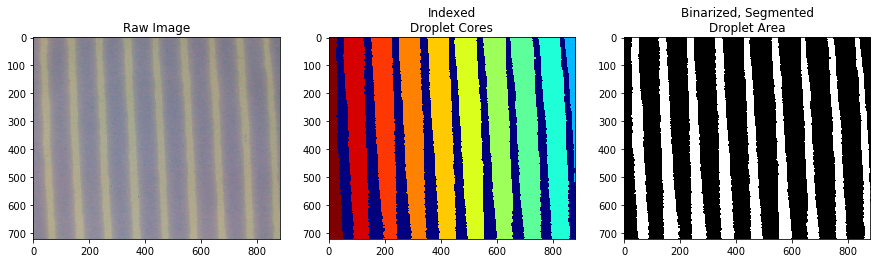

Sample # 17 
Count Loss =  0.9067 
Area Loss =  0.3249 
Geometric Loss =  0.8035 
FINAL LOSS SCORE =  0.678 


Sample # 18 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 19 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




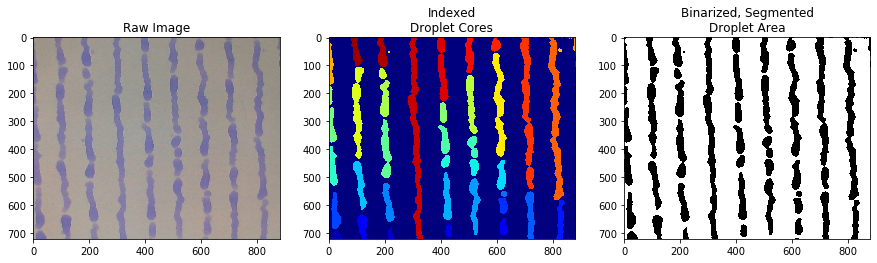

Sample # 20 
Count Loss =  0.68 
Area Loss =  0.7776 
Geometric Loss =  0.7603 
FINAL LOSS SCORE =  0.739 




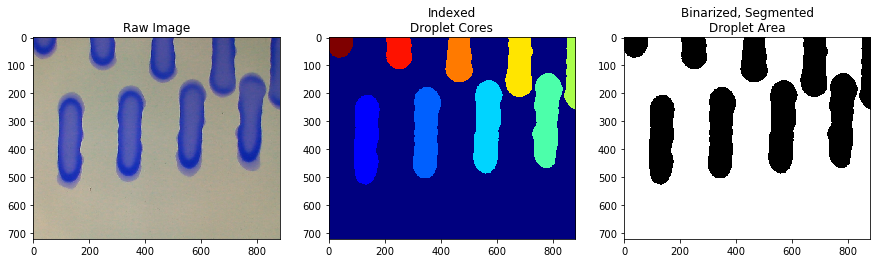

Sample # 21 
Count Loss =  0.9333 
Area Loss =  0.7485 
Geometric Loss =  0.5348 
FINAL LOSS SCORE =  0.739 




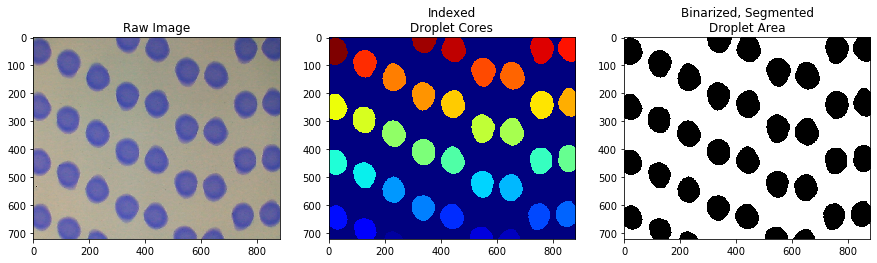

Sample # 22 
Count Loss =  0.7533 
Area Loss =  0.6868 
Geometric Loss =  0.1483 
FINAL LOSS SCORE =  0.529 




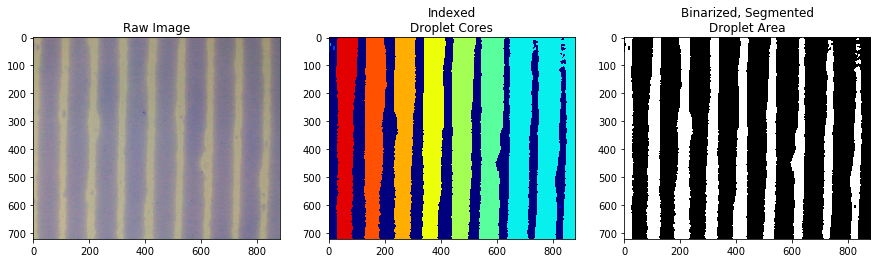

Sample # 23 
Count Loss =  0.92 
Area Loss =  0.3363 
Geometric Loss =  0.7381 
FINAL LOSS SCORE =  0.665 




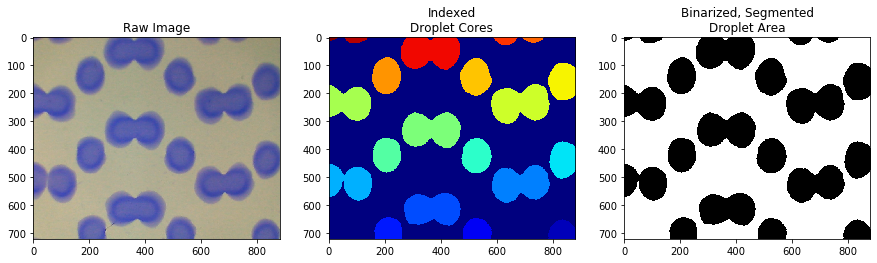

Sample # 24 
Count Loss =  0.86 
Area Loss =  0.6552 
Geometric Loss =  0.3155 
FINAL LOSS SCORE =  0.61 




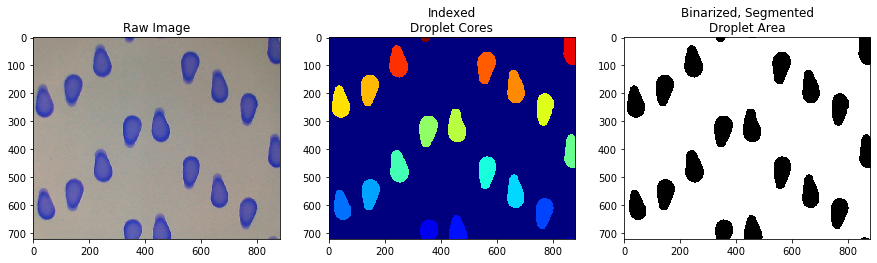

Sample # 25 
Count Loss =  0.8533 
Area Loss =  0.8512 
Geometric Loss =  0.3701 
FINAL LOSS SCORE =  0.692 




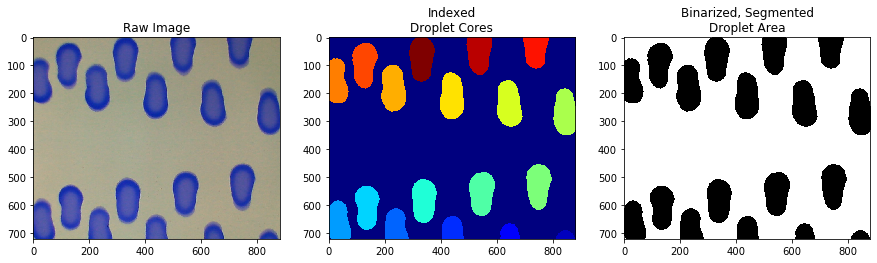

Sample # 26 
Count Loss =  0.8733 
Area Loss =  0.7353 
Geometric Loss =  0.3562 
FINAL LOSS SCORE =  0.655 


Sample # 27 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




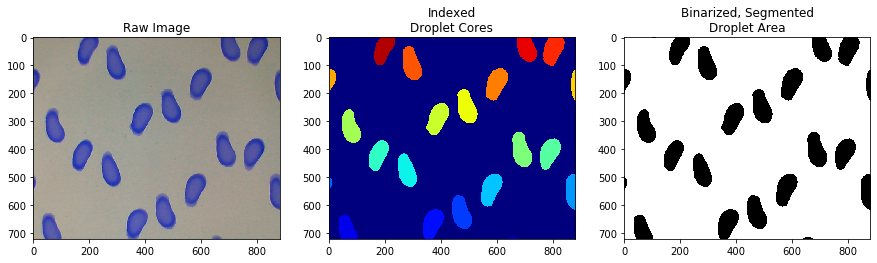

Sample # 28 
Count Loss =  0.8467 
Area Loss =  0.843 
Geometric Loss =  0.3858 
FINAL LOSS SCORE =  0.692 




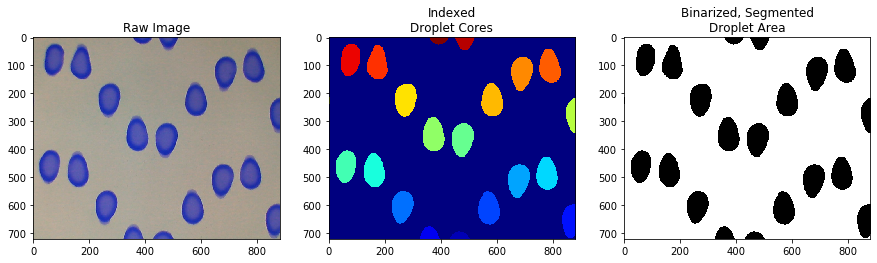

Sample # 29 
Count Loss =  0.8533 
Area Loss =  0.8203 
Geometric Loss =  0.2932 
FINAL LOSS SCORE =  0.656 


Sample # 30 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 31 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 32 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 33 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 34 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




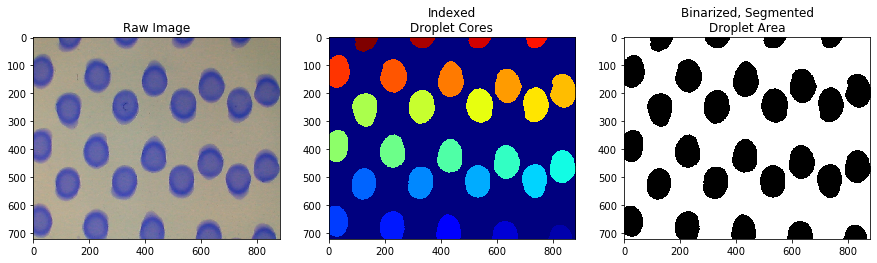

Sample # 35 
Count Loss =  0.8133 
Area Loss =  0.6991 
Geometric Loss =  0.1958 
FINAL LOSS SCORE =  0.569 




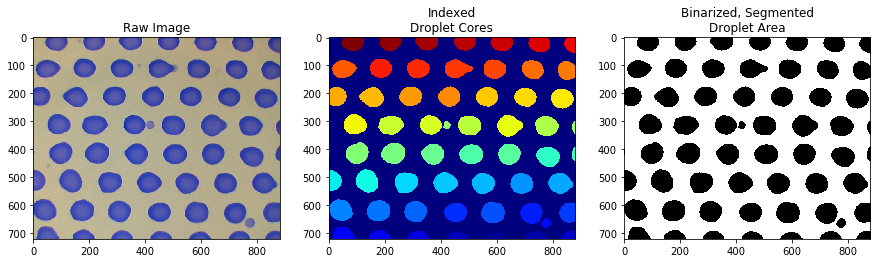

Sample # 36 
Count Loss =  0.6 
Area Loss =  0.6576 
Geometric Loss =  0.1526 
FINAL LOSS SCORE =  0.47 


Sample # 37 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 38 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




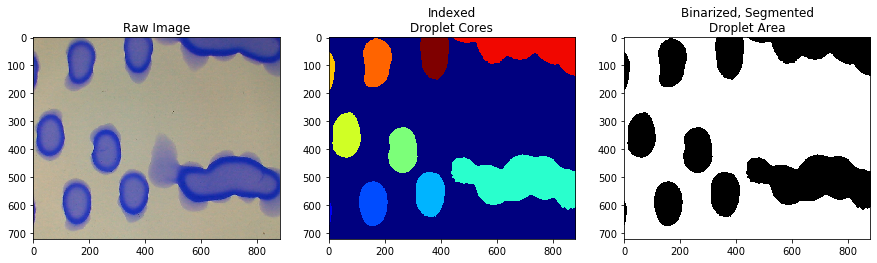

Sample # 39 
Count Loss =  0.9267 
Area Loss =  0.7282 
Geometric Loss =  0.4428 
FINAL LOSS SCORE =  0.699 




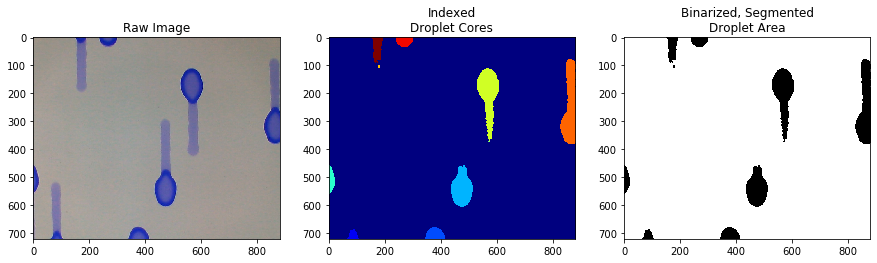

Sample # 40 
Count Loss =  0.9267 
Area Loss =  0.9385 
Geometric Loss =  0.5806 
FINAL LOSS SCORE =  0.815 


Sample # 41 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 42 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 43 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 44 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




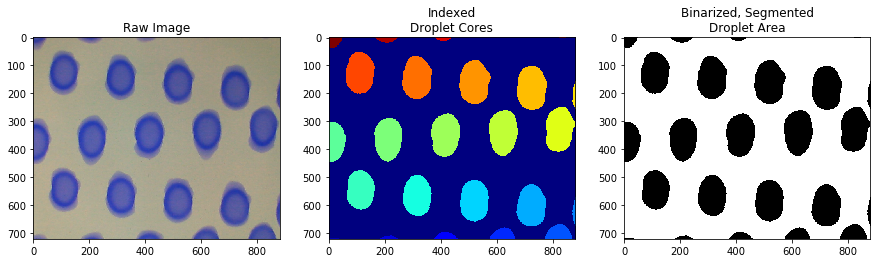

Sample # 45 
Count Loss =  0.8333 
Area Loss =  0.7297 
Geometric Loss =  0.2581 
FINAL LOSS SCORE =  0.607 


Sample # 46 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 47 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 48 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




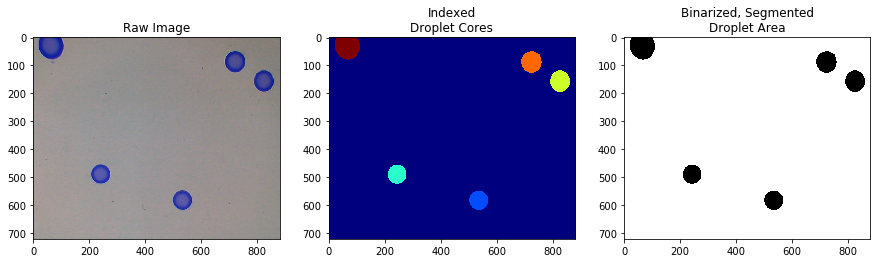

Sample # 49 
Count Loss =  0.96 
Area Loss =  0.9654 
Geometric Loss =  0.0734 
FINAL LOSS SCORE =  0.666 


Sample # 50 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




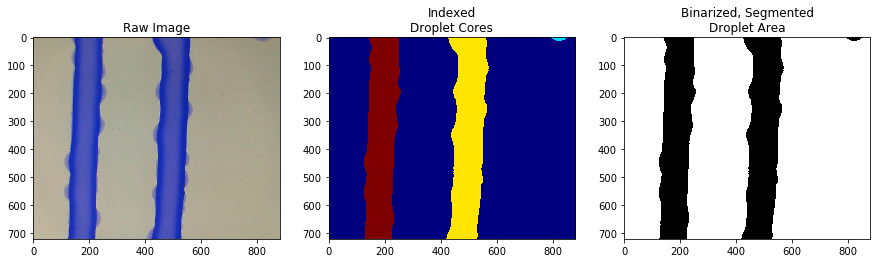

Sample # 51 
Count Loss =  0.9733 
Area Loss =  0.7648 
Geometric Loss =  0.7439 
FINAL LOSS SCORE =  0.827 




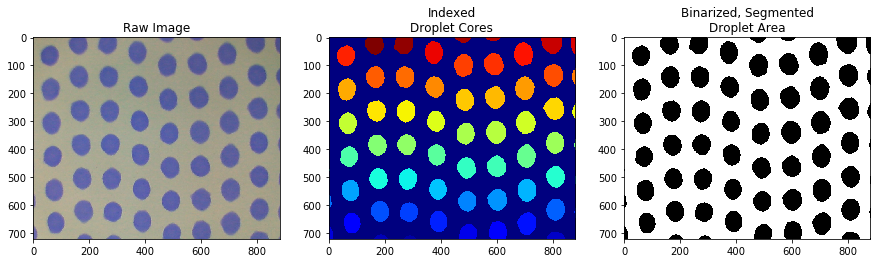

Sample # 52 
Count Loss =  0.5733 
Area Loss =  0.6906 
Geometric Loss =  0.1267 
FINAL LOSS SCORE =  0.464 


Sample # 53 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 54 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 55 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 56 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 


Sample # 57 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




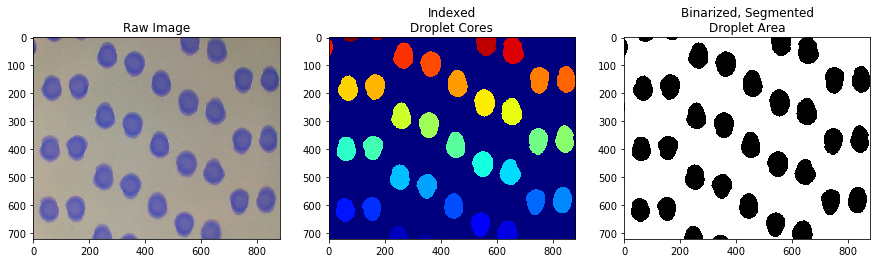

Sample # 58 
Count Loss =  0.76 
Area Loss =  0.7649 
Geometric Loss =  0.1833 
FINAL LOSS SCORE =  0.569 


Sample # 59 
Count Loss =  1 
Area Loss =  1 
Geometric Loss =  1 
FINAL LOSS SCORE =  1.0 




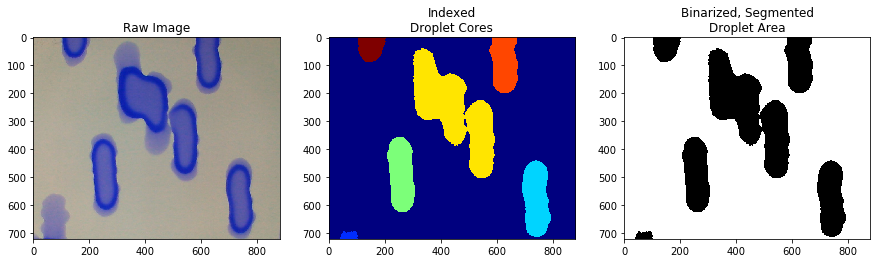

Sample # 60 
Count Loss =  0.9533 
Area Loss =  0.792 
Geometric Loss =  0.492 
FINAL LOSS SCORE =  0.746 




In [14]:
# assign weights for loss function
w_count=1
w_area=1
w_geom=1
cv_x = np.zeros((batch,3)) # create conditions matrix where columns are printing conditions and rows are the number of samples
cv_y = np.zeros((batch,1)) # create label matrix corresponding to each of the conditions
for x in range(batch): # number of samples
    cv_x[x,:]=conds[x] # populate condtion matrix
    if failure_log[x+1] == True: # bad sample
        count_loss=1
        area_loss=1
        geom_loss=1
        w_count=1
        w_area=1
        w_geom=1
        total_loss=(w_count*count_loss + w_area*area_loss + w_geom*geom_loss)/(w_count+w_area+w_geom) # set total loss to 1
        cv_y[x,0]=total_loss
        drop_number[x]=0 # if we have a failed sample, # drops = 0
    else:
        img=images[x]
        # for double_watershed=False, we don't utilize the remove_log
        count_loss,area_loss,geom_loss,total_loss,num_droplets,binarized=CV_loss_label(img=img,w_count=w_count,w_area=w_area,w_geom=w_geom,double_watershed=False, rotate_crop_params={'theta':0,'x1':300,'x2':1180,'y1':0,'y2':720}, large_elements_pixels=3000, pixel_diff=2000,drop_dilate=5,remove_log=remove_log[x]) # calculate losses from CV algorithm
        cv_y[x,0]=total_loss # populate label matrix
        drop_number[x]=num_droplets
#         if x+1>20:
#             data_path='C:/Users/alexs/Dropbox (MIT)/Buonassisi-Group/ASD Team/Archerfish/05_Data/Imaged_droplets/Inkjet_compiled_data_april2021/'
#             plt.imshow(binarized,cmap='Greys')
#             plt.savefig(data_path+str(x+1+60+60-20-20)+'.png')
    print('Sample #',x+1,
          '\nCount Loss = ',np.round(count_loss,4),
          '\nArea Loss = ',np.round(area_loss,4),
          '\nGeometric Loss = ', np.round(geom_loss,4),
          '\nFINAL LOSS SCORE = ',np.round(total_loss,3),
          '\n=================================================================\n\n')

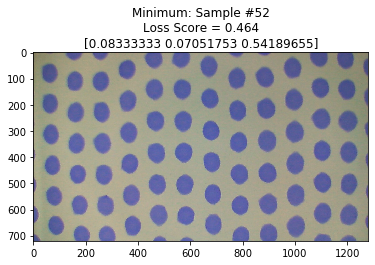

In [15]:
# Show sample with minimum objective fucntion value (the best sample)
plt.imshow(images[np.argmin(cv_y)])
plt.title('Minimum: Sample #'+str(np.argmin(cv_y)+1)+'\nLoss Score = '+str(np.round(np.min(cv_y),3))+'\n'+str(cv_x[np.argmin(cv_y),:]))
plt.show()

In [16]:
BO=BO_optimizer_func(X=cv_x,Y=cv_y,batch_size=10) # output 10 predicted points per round
x_next=BO.suggest_next_locations()
y_next=BO.model.predict(x_next)[0] # [0] value is mean prediction and [1] value is STD of the prediction
x_next_raw=x_next*(max_conds-min_conds)+min_conds # re-scale standardized values to raw values using only the initialization data
print('BO PREDICTED CONDITIONS')
for n in range(x_next.shape[0]):
  print('\n','='*40,'\nOPTIMUM #',str(n+1),
  '\n\nPressure (MPa) = ',round(x_next_raw[n,0],3),
  '\nFrequency (Hz) = ',round(x_next_raw[n,1],3),
  '\nSpeed (%) = ',round(x_next_raw[n,2],3),
  '\nPredicted Loss Score = ',round(y_next[n][0],3),'\n',
  '='*40,'\n')
# np.savetxt(path+'MPI_round5_xnext.csv',x_next_raw,delimiter=',')
# np.savetxt(path+'MPI_round5_ynext.csv',y_next,delimiter=',')

BO PREDICTED CONDITIONS

OPTIMUM # 1 

Pressure (MPa) =  0.137 
Frequency (Hz) =  1.0 
Speed (%) =  205.108 
Predicted Loss Score =  0.643 


OPTIMUM # 2 

Pressure (MPa) =  0.052 
Frequency (Hz) =  1.0 
Speed (%) =  205.657 
Predicted Loss Score =  0.643 


OPTIMUM # 3 

Pressure (MPa) =  0.03 
Frequency (Hz) =  10.932 
Speed (%) =  175.343 
Predicted Loss Score =  0.66 


OPTIMUM # 4 

Pressure (MPa) =  0.149 
Frequency (Hz) =  23.077 
Speed (%) =  220.074 
Predicted Loss Score =  0.657 


OPTIMUM # 5 

Pressure (MPa) =  0.032 
Frequency (Hz) =  10.399 
Speed (%) =  237.339 
Predicted Loss Score =  0.66 


OPTIMUM # 6 

Pressure (MPa) =  0.148 
Frequency (Hz) =  1.269 
Speed (%) =  175.932 
Predicted Loss Score =  0.655 


OPTIMUM # 7 

Pressure (MPa) =  0.085 
Frequency (Hz) =  3.403 
Speed (%) =  222.438 
Predicted Loss Score =  0.648 


OPTIMUM # 8 

Pressure (MPa) =  0.138 
Frequency (Hz) =  2.751 
Speed (%) =  275.534 
Predicted Loss Score =  0.693 


OPTIMUM # 9 

Pressure (MPa